## Using AntiNex to Make Predictions with a Pre-trained Deep Neural Network

![alt text](https://imgur.com/uXO9dCE.png "AntiNex Image")

#### This notebook requires running the AntiNex stack locally. The easiest way is to use docker-compose, but you can also run it manually.

## What is AntiNex?

AntiNex is a free tool for helping anyone defend against software attacks. It helps users train highly accurate Deep Neural Networks (dnn’s) from specialized datasets. These datasets are captured network traffic packets in the OSI layers 2, 3, 4 and 5. Once labeled as attack and non-attack records, you can use your dnn’s for identifying attack records across the network. With this approach, AntiNex can predict attacks on web applications like: Django, Flask, React and Redux, Vue, and Spring with repeatable accuracies above **99.8%**. By default just one AntiNex Core (core) worker manages 100 pre-trained dnn’s in memory for making faster predictions and support for manual retraining as needed based off new datasets.

## For the Latest Documentation

http://antinex.readthedocs.io/en/latest

## Running AntiNex with Docker-Compose


If you have docker-compose you can run the following commands to download all the containers and run the full stack locally (the [ai-core container](https://hub.docker.com/r/jayjohnson/ai-core/) is ~2.5 GB so it can take a couple minutes to download):

Create a python 3 virtualenv, install the AntiNex Python Client and clone the Repo:

```
virtualenv -p python3 ~/.venvs/testing
source ~/.venvs/testing/bin/activate
pip install antinex-client
git clone https://github.com/jay-johnson/train-ai-with-django-swagger-jwt /opt/antinex-api
cd /opt/antinex-api
```


## Start the AntiNex Stack

This will start docker containers running: the ai-core, Jupyter, Redis, Postgres, and pgAdmin.

This can take a few minutes to download. Here is the docker compose file if you want to review it before you run something on your system:
https://github.com/jay-johnson/train-ai-with-django-swagger-jwt/blob/master/compose.yml


```
./run-all.sh 
Starting all containers with: compose.yml
Creating redis    ... done
Creating jupyter  ... done
Creating pgadmin  ... done
Creating postgres ... done
Creating api      ... done
Creating core     ... done
Creating worker   ... done
Creating pipeline ... done
```

## Verify AntiNex is Running

```
docker ps
CONTAINER ID        IMAGE                       COMMAND                  CREATED             STATUS              PORTS                    NAMES
cb0d0e8e582e        jayjohnson/ai-core:latest   "/bin/sh -c 'cd /opt…"   33 seconds ago      Up 32 seconds                                worker
4b0c44c99472        jayjohnson/ai-core:latest   "/bin/sh -c 'cd /opt…"   33 seconds ago      Up 32 seconds                                pipeline
bd3c488036dd        jayjohnson/ai-core:latest   "/bin/sh -c 'cd /opt…"   34 seconds ago      Up 33 seconds                                core
a3093e2632b7        jayjohnson/ai-core:latest   "/bin/sh -c 'cd /opt…"   34 seconds ago      Up 33 seconds                                api
3839a0af82ec        jayjohnson/pgadmin4:1.0.0   "python ./usr/local/…"   35 seconds ago      Up 33 seconds       0.0.0.0:83->5050/tcp     pgadmin
b4ea601f28cd        redis:4.0.5-alpine          "docker-entrypoint.s…"   35 seconds ago      Up 33 seconds       0.0.0.0:6379->6379/tcp   redis
c5eb07041509        postgres:10.2-alpine        "docker-entrypoint.s…"   35 seconds ago      Up 34 seconds       0.0.0.0:5432->5432/tcp   postgres
9da0440864e0        jayjohnson/ai-core:latest   "/opt/antinex-core/d…"   35 seconds ago      Up 34 seconds                                jupyter
```


## Migrate the DB

SSH into the Django container and run the migration to set up the database:

```
docker exec -it worker bash
cd /opt/antinex-api
./run-migrations.sh
exit
```


## Here's how to Watch what the Containers are Doing

From the ``/opt/antinex-api`` directory you can use these shell scripts to watch the logs on the following containers:

### AntiNex Core:
docker logs -f core

### AntiNex REST API:
docker logs -f api

### AntiNex REST API Celery Worker:
docker logs -f worker

## Set Up the AntiNex Client

In [1]:
import os
import sys
import json
import pandas as pd
from antinex_client.log.setup_logging import build_colorized_logger
from antinex_client.utils import ev
from antinex_client.utils import ppj
from antinex_client.ai_client import AIClient
from antinex_client.consts import LOGIN_FAILED
from antinex_client.consts import SUCCESS
from antinex_client.consts import ERROR
from antinex_client.consts import FAILED
import matplotlib.pyplot as plt
import seaborn as sns

## Name this Analysis and set up the logger

In [2]:
name = "ai-protect-django"
log = build_colorized_logger(name=name)
log.info("starting from notebook")

2018-03-30 19:32:50,878 - ai-protect-django - INFO - starting from notebook


## Set Up Credentials

By default the only allowed user on the system is **root** with a password of **123321**.

In [3]:
user = ev("ANTINEX_USER", "root")
password = ev("ANTINEX_PUBLISH_TO_CORE", "123321")
email = ev("ANTINEX_EMAIL", "notreal@email.com")
url = ev("ANTINEX_URL", "http://localhost:8080")
datafile = ev("DATAFILE", "/opt/antinex-api/tests/only-publish-scaler-full-django.json")
verbose = bool(str(ev("API_VERBOSE", "true")).lower() == "true")
debug = bool(str(ev("API_DEBUG", "false")).lower() == "true")

if not os.path.exists(datafile):
    log.error("Did not find datafile={}".format(datafile))
else:
    log.info("Using user={} with AntiNex running at url={} datafile={}".format(user, url, datafile))

2018-03-30 19:32:50,900 - ai-protect-django - INFO - Using user=root with AntiNex running at url=http://localhost:8080 datafile=/opt/antinex-api/tests/only-publish-scaler-full-django.json


## Create the AntiNex Client

The AntiNex Client repository is available here:

https://github.com/jay-johnson/antinex-client

In [4]:
# https://github.com/jay-johnson/antinex-client/blob/master/antinex_client/ai_client.py
client = AIClient(
    user=user,
    email=email,
    password=password,
    url=url,
    verbose=verbose,
    debug=debug)

In [5]:
# Load the dataset file as an dictionary
req_body = None
with open(datafile, "r") as f:
    req_body = json.loads(f.read())
    
log.info("loaded request_file={} which will be POST-ed as an HTTP JSON dictionary={}".format(datafile, ppj(req_body)))

2018-03-30 19:32:50,917 - ai-protect-django - INFO - loaded request_file=/opt/antinex-api/tests/only-publish-scaler-full-django.json which will be POST-ed as an HTTP JSON dictionary={
    "batch_size": 32,
    "dataset": "/opt/antinex-datasets/v1/webapps/django/training-ready/v1_django_cleaned.csv",
    "epochs": 15,
    "features_to_process": [
        "idx",
        "arp_hwlen",
        "arp_hwtype",
        "arp_id",
        "arp_op",
        "arp_plen",
        "arp_ptype",
        "dns_default_aa",
        "dns_default_ad",
        "dns_default_an",
        "dns_default_ancount",
        "dns_default_ar",
        "dns_default_arcount",
        "dns_default_cd",
        "dns_default_id",
        "dns_default_length",
        "dns_default_ns",
        "dns_default_nscount",
        "dns_default_opcode",
        "dns_default_qd",
        "dns_default_qdcount",
        "dns_default_qr",
        "dns_default_ra",
        "dns_default_rcode",
        "dns_default_rd",
        "dns_defau

## Load the Model into the AntiNex Core

This will take a few moments

In [6]:
log.info("starting job")
response = client.run_job(body=req_body)
log.info("done with job")

2018-03-30 19:32:50,924 - ai-protect-django - INFO - starting job
2018-03-30 19:32:50,925 - ai-client - INFO - user=root starting job={'label': 'Full-Django-AntiNex-S
2018-03-30 19:32:50,934 - ai-client - INFO - log in user=root url=http://localhost:8080/api-token-auth/ ca_file=None cert=None
2018-03-30 19:32:51,138 - ai-client - INFO - added job=13 result=13 all_jobs=1 all_results=1
2018-03-30 19:32:51,140 - ai-protect-django - INFO - done with job


In [7]:
# Handle Response Results
if response["status"] == SUCCESS:
    log.info(("job started successfully with response={}")
             .format(ppj(response["data"])))
elif response["status"] == FAILED:
    log.error(("job failed with error='{}' with response={}")
              .format(response["error"], ppj(response["data"])))
elif response["status"] == ERROR:
    log.error(("job had an error='{}' with response={}")
              .format(response["error"], ppj(response["data"])))
elif response["status"] == LOGIN_FAILED:
    log.error(("job reported user was not able to log in "
               "with an error='{}' with response={}")
              .format(response["error"], ppj(response["data"]))) 

2018-03-30 19:32:51,165 - ai-protect-django - INFO - job started successfully with response={
    "job": {
        "algo_name": "Full-Django-AntiNex-Simple-Scaler-DNN",
        "control_state": "active",
        "created": "2018-03-30 19:32:51",
        "deleted": "",
        "desc": null,
        "ds_name": "Full-Django-AntiNex-Simple-Scaler-DNN",
        "id": 13,
        "meta_data": {},
        "ml_type": "classification",
        "post_proc": {},
        "pre_proc": {},
        "predict_feature": "label_value",
        "predict_manifest": {
            "apply_scaler": true,
            "batch_size": 32,
            "csv_file": null,
            "dataset": "/opt/antinex-datasets/v1/webapps/django/training-ready/v1_django_cleaned.csv",
            "epochs": 15,
            "features_to_process": [
                "idx",
                "arp_hwlen",
                "arp_hwtype",
                "arp_id",
                "arp_op",
                "arp_plen",
                "arp_ptype

## How AntiNex Trains a Deep Neural Network

![Training a Deep Neural Network](https://imgur.com/M1vwVoW.png "Training a Deep Neural Network")

## Wait for the Training Job to Finish

This can take a few minutes depending on how fast your system is...

In [8]:
res_data = response["data"]
job_data = res_data.get("job", None)
result_data = res_data.get("results", None)
if not job_data:
    log.error(("missing job dictionary in response data={}")
              .format(response["data"]))
if not result_data:
    log.error(("missing results dictionary in response data={}")
              .format(response["data"]))

In [9]:
job_id = job_data.get("id", None)
job_status = job_data.get("status", None)
result_id = result_data.get("id", None)
result_status = result_data.get("status", None)

log.info(("started job.id={} job.status={} with result.id={} result.status={}")
         .format(job_id, job_status, result_id, result_status))

job_results = client.wait_for_job_to_finish(job_id=job_id)
if job_results["status"] != SUCCESS:
    log.error(("failed waiting for job.id={} to finish error={} data={}")
              .format(job_id, job_results["error"], job_results["data"]))

2018-03-30 19:32:51,217 - ai-protect-django - INFO - started job.id=13 job.status=initial with result.id=13 result.status=initial


In [10]:
final_job = job_results["data"]["job"]
final_result = job_results["data"]["result"]
accuracy = final_result["acc_data"]["accuracy"]
predictions = final_result["predictions_json"].get("predictions", [])

In [11]:
log.info(("loading predictions={} with accuracy={} into pandas dataframe")
         .format(len(predictions), accuracy))

train_results_df = pd.DataFrame(predictions)

log.info(("columns in dataframe with columns={}"
          .format(train_results_df.columns.values)))

2018-03-30 19:33:21,230 - ai-protect-django - INFO - loading predictions=30200 with accuracy=99.82615894039735 into pandas dataframe
2018-03-30 19:33:21,763 - ai-protect-django - INFO - columns in dataframe with columns=['_count' '_original_label_value' '_row_idx' 'arp_hwlen' 'arp_hwtype'
 'arp_id' 'arp_op' 'arp_plen' 'arp_ptype' 'dns_default_aa'
 'dns_default_ad' 'dns_default_an' 'dns_default_ancount' 'dns_default_ar'
 'dns_default_arcount' 'dns_default_cd' 'dns_default_id'
 'dns_default_length' 'dns_default_ns' 'dns_default_nscount'
 'dns_default_opcode' 'dns_default_qd' 'dns_default_qdcount'
 'dns_default_qr' 'dns_default_ra' 'dns_default_rcode' 'dns_default_rd'
 'dns_default_tc' 'dns_default_z' 'dns_id' 'eth_id' 'eth_type'
 'icmp_addr_mask' 'icmp_code' 'icmp_gw' 'icmp_id' 'icmp_ptr' 'icmp_seq'
 'icmp_ts_ori' 'icmp_ts_rx' 'icmp_ts_tx' 'icmp_type' 'icmp_unused' 'idx'
 'ip_id' 'ip_ihl' 'ip_len' 'ip_tos' 'ip_version' 'ipv6_fl' 'ipv6_hlim'
 'ipv6_nh' 'ipv6_plen' 'ipv6_tc' 'ipv6_version'

## Process Predictions and Determine Actual Accuracy

In [12]:
# this can lock up your notebook if you set it to True... give it a minute to finish
show_success = False
show_error = False

predict_feature = "label_value"
org_value_col = "_original_{}".format(predict_feature)
num_misses = 0
actual_train_results = []
for row_num, row in train_results_df.iterrows():
    org_value = row[org_value_col]
    predicted_value = row[predict_feature]
    if (org_value == -1.0 and predicted_value != 0) or (org_value == 1.0 and predicted_value != 1):
        if show_error:
            log.error(("row={} original_{}={} predicted={}")
                      .format(
                        row_num,
                        predict_feature,
                        org_value,
                        predicted_value))
        num_misses += 1
        actual_train_results.append({"label": "bad", "prediction_status": 1})
    else:
        if show_success:
            log.info(("row={} original_{}={} predicted={}")
                     .format(
                        row_num,
                        predict_feature,
                        org_value,
                        predicted_value))
        actual_train_results.append({"label": "good", "prediction_status": 0})
# end seeing original vs predicted

## Show Actual Accuracy and Incorrect Predictions

In [13]:
total_rows = len(train_results_df.index)
predicted_accuracy = 1.0 - float(float(num_misses) / float(total_rows))

log.info("Number of Incorrect Predictions: {}/{}".format(num_misses, total_rows))
log.info("Predicted Accuracy was: {}%".format(predicted_accuracy))

2018-03-30 19:33:24,142 - ai-protect-django - INFO - Number of Incorrect Predictions: 45/30200
2018-03-30 19:33:24,148 - ai-protect-django - INFO - Predicted Accuracy was: 0.9985099337748344%


## Show Prediction Distributions
### 0.0 values are Correct predictions
### 1.0 values are Incorrect predictions

/opt/venvs/venvdrfpipeline/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


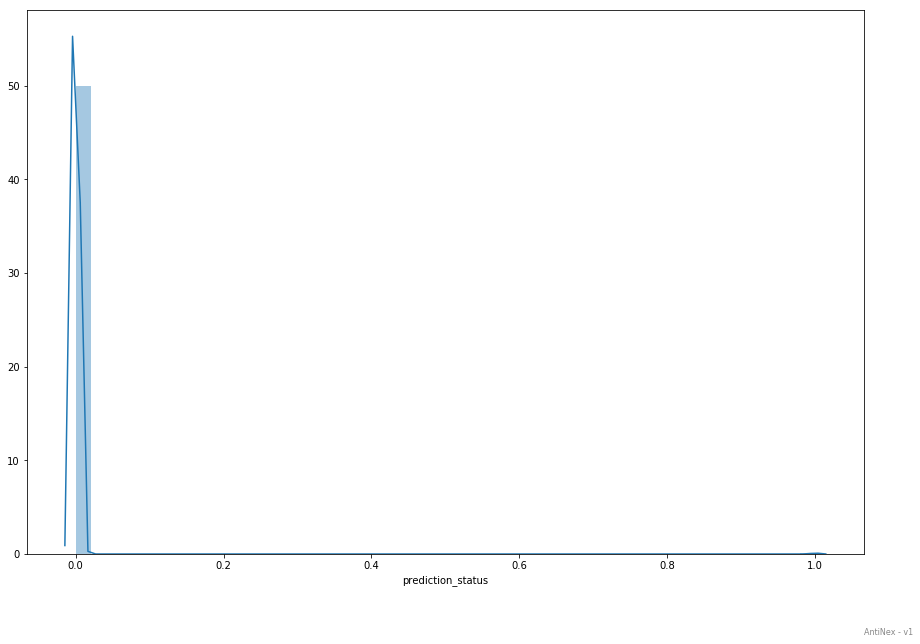

In [14]:
fig, ax = plt.subplots(figsize=(15.0, 10.0))
actual_train_results_df = pd.DataFrame(actual_train_results)
ax = sns.distplot(actual_train_results_df["prediction_status"])
ax.get_figure().text(0.90, 0.01, "AntiNex - v1", va="bottom", fontsize=8, color="#888888")
plt.show()

## Make New Predictions with the Pre-Trained Deep Neural Network

In [15]:
# use the same HTTP request... AntiNex will do the rest
log.info("starting job")
new_predictions_response = client.run_job(body=req_body)
log.info("done with job")

2018-03-30 19:33:24,606 - ai-protect-django - INFO - starting job
2018-03-30 19:33:24,609 - ai-client - INFO - user=root starting job={'label': 'Full-Django-AntiNex-S
2018-03-30 19:33:24,706 - ai-client - INFO - added job=14 result=14 all_jobs=2 all_results=2
2018-03-30 19:33:24,710 - ai-protect-django - INFO - done with job


## How AntiNex Makes New Predictions using a Pre-trained Deep Neural Network

Notice there is no longer a requirement to have the CSV datasets on disk

![Predictions using a Pre-trained Deep Neural Network](https://imgur.com/PkjCkZk.png "Predictions using a Pre-trained Deep Neural Network")

In [16]:
# Handle New Prediction Response Results
if new_predictions_response["status"] == SUCCESS:
    log.info(("job started successfully with response={}")
             .format(ppj(new_predictions_response["data"])))
elif new_predictions_response["status"] == FAILED:
    log.error(("job failed with error='{}' with response={}")
              .format(new_predictions_response["error"], ppj(new_predictions_response["data"])))
elif new_predictions_response["status"] == ERROR:
    log.error(("job had an error='{}' with response={}")
              .format(new_predictions_response["error"], ppj(new_predictions_response["data"])))
elif new_predictions_response["status"] == LOGIN_FAILED:
    log.error(("job reported user was not able to log in "
               "with an error='{}' with response={}")
              .format(new_predictions_response["error"], ppj(new_predictions_response["data"]))) 

2018-03-30 19:33:24,752 - ai-protect-django - INFO - job started successfully with response={
    "job": {
        "algo_name": "Full-Django-AntiNex-Simple-Scaler-DNN",
        "control_state": "active",
        "created": "2018-03-30 19:33:24",
        "deleted": "",
        "desc": null,
        "ds_name": "Full-Django-AntiNex-Simple-Scaler-DNN",
        "id": 14,
        "meta_data": {},
        "ml_type": "classification",
        "post_proc": {},
        "pre_proc": {},
        "predict_feature": "label_value",
        "predict_manifest": {
            "apply_scaler": true,
            "batch_size": 32,
            "csv_file": null,
            "dataset": "/opt/antinex-datasets/v1/webapps/django/training-ready/v1_django_cleaned.csv",
            "epochs": 15,
            "features_to_process": [
                "idx",
                "arp_hwlen",
                "arp_hwtype",
                "arp_id",
                "arp_op",
                "arp_plen",
                "arp_ptype

In [17]:
new_res_data = new_predictions_response["data"]
new_job_data = new_res_data.get("job", None)
new_result_data = new_res_data.get("results", None)
if not new_job_data:
    log.error(("missing job dictionary in response data={}")
              .format(new_predictions_response["data"]))
if not new_result_data:
    log.error(("missing results dictionary in response data={}")
              .format(new_predictions_response["data"]))

In [18]:
# Get the Job and Result DB IDs out
new_job_id = new_job_data.get("id", None)
new_job_status = new_job_data.get("status", None)
new_result_id = new_result_data.get("id", None)
new_result_status = new_result_data.get("status", None)

log.info(("started making New Predictions with job.id={} job.status={} with result.id={} result.status={}")
         .format(new_job_id, new_job_status, new_result_id, new_result_status))

new_job_results = client.wait_for_job_to_finish(job_id=new_job_id)
if new_job_results["status"] != SUCCESS:
    log.error(("failed waiting for New Predictions job.id={} to finish error={} data={}")
              .format(new_job_id, new_job_results["error"], new_job_results["data"]))

2018-03-30 19:33:24,805 - ai-protect-django - INFO - started making New Predictions with job.id=14 job.status=initial with result.id=14 result.status=initial


In [19]:
new_final_job = new_job_results["data"]["job"]
new_final_result = new_job_results["data"]["result"]
new_accuracy = new_final_result["acc_data"]["accuracy"]
new_predictions = new_final_result["predictions_json"].get("predictions", [])

In [20]:
log.info(("loading New predictions={} with accuracy={} into pandas dataframe")
         .format(len(new_predictions), new_accuracy))

new_train_results_df = pd.DataFrame(new_predictions)

log.info(("columns in dataframe with columns={}"
          .format(new_train_results_df.columns.values)))

2018-03-30 19:33:54,706 - ai-protect-django - INFO - loading New predictions=30200 with accuracy=99.82615894039735 into pandas dataframe
2018-03-30 19:33:55,218 - ai-protect-django - INFO - columns in dataframe with columns=['_count' '_original_label_value' '_row_idx' 'arp_hwlen' 'arp_hwtype'
 'arp_id' 'arp_op' 'arp_plen' 'arp_ptype' 'dns_default_aa'
 'dns_default_ad' 'dns_default_an' 'dns_default_ancount' 'dns_default_ar'
 'dns_default_arcount' 'dns_default_cd' 'dns_default_id'
 'dns_default_length' 'dns_default_ns' 'dns_default_nscount'
 'dns_default_opcode' 'dns_default_qd' 'dns_default_qdcount'
 'dns_default_qr' 'dns_default_ra' 'dns_default_rcode' 'dns_default_rd'
 'dns_default_tc' 'dns_default_z' 'dns_id' 'eth_id' 'eth_type'
 'icmp_addr_mask' 'icmp_code' 'icmp_gw' 'icmp_id' 'icmp_ptr' 'icmp_seq'
 'icmp_ts_ori' 'icmp_ts_rx' 'icmp_ts_tx' 'icmp_type' 'icmp_unused' 'idx'
 'ip_id' 'ip_ihl' 'ip_len' 'ip_tos' 'ip_version' 'ipv6_fl' 'ipv6_hlim'
 'ipv6_nh' 'ipv6_plen' 'ipv6_tc' 'ipv6_vers

## Process New Predictions and Determine Actual Accuracy

In [21]:
# this can lock up your notebook if you set it to True... give it a minute to finish
show_success = False
show_error = False

predict_feature = "label_value"
org_value_col = "_original_{}".format(predict_feature)
new_num_misses = 0
new_actual_train_results = []
for row_num, row in new_train_results_df.iterrows():
    org_value = row[org_value_col]
    predicted_value = row[predict_feature]
    if (org_value == -1.0 and predicted_value != 0) or (org_value == 1.0 and predicted_value != 1):
        if show_error:
            log.error(("row={} original_{}={} predicted={}")
                      .format(
                        row_num,
                        predict_feature,
                        org_value,
                        predicted_value))
        new_num_misses += 1
        new_actual_train_results.append({"label": "bad", "prediction_status": 1})
    else:
        if show_success:
            log.info(("row={} original_{}={} predicted={}")
                     .format(
                        row_num,
                        predict_feature,
                        org_value,
                        predicted_value))
        new_actual_train_results.append({"label": "good", "prediction_status": 0})
# end seeing original vs predicted

## Show Actual Accuracy and Incorrect Predictions

In [22]:
new_total_rows = len(new_train_results_df.index)
new_predicted_accuracy = 1.0 - float(float(new_num_misses) / float(new_total_rows))

log.info("Original Number of Incorrect Predictions: {}/{}".format(num_misses, total_rows))
log.info("Original Predicted Accuracy was: {}%".format(predicted_accuracy))

log.info("New Number of Incorrect Predictions: {}/{}".format(new_num_misses, new_total_rows))
log.info("New Predicted Accuracy was: {}%".format(new_predicted_accuracy))

2018-03-30 19:33:57,624 - ai-protect-django - INFO - Original Number of Incorrect Predictions: 45/30200
2018-03-30 19:33:57,627 - ai-protect-django - INFO - Original Predicted Accuracy was: 0.9985099337748344%
2018-03-30 19:33:57,628 - ai-protect-django - INFO - New Number of Incorrect Predictions: 45/30200
2018-03-30 19:33:57,631 - ai-protect-django - INFO - New Predicted Accuracy was: 0.9985099337748344%


## Show Prediction Distributions
### 0.0 values are Correct predictions
### 1.0 values are Incorrect predictions

/opt/venvs/venvdrfpipeline/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


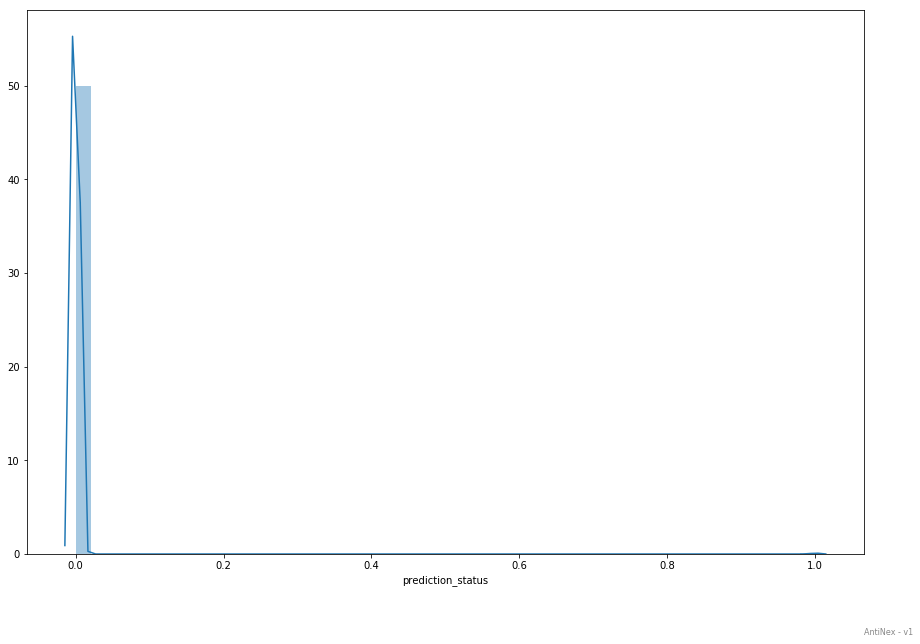

In [23]:
fig, ax = plt.subplots(figsize=(15.0, 10.0))
new_actual_train_results_df = pd.DataFrame(new_actual_train_results)
ax = sns.distplot(new_actual_train_results_df["prediction_status"])
ax.get_figure().text(0.90, 0.01, "AntiNex - v1", va="bottom", fontsize=8, color="#888888")
plt.show()

## Thanks for Reading!

I hope you found it worthwhile

## Please reach out if you are interested in helping

https://github.com/jay-johnson/train-ai-with-django-swagger-jwt

https://github.com/jay-johnson/antinex-core

https://github.com/jay-johnson/network-pipeline

https://github.com/jay-johnson/antinex-client

https://github.com/jay-johnson/antinex-utils

https://github.com/jay-johnson/antinex-datasets

https://github.com/jay-johnson/network-pipeline-datasets

## Latest Documentation

http://antinex.readthedocs.io/en/latest